# Exercise 07 (Module 09)
Hao-Tien Kuo

## Section 1: Time Series (continued from Lab)

In [2]:
import numpy as np
import pandas as pd
import statistics
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('Alcohol_Sales.csv')

df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce', format='%B-%y')
df.set_index('DATE', inplace=True)
df.head()

,units_sold
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [3]:
# From the lab, we saw the series had non-constant variance. Transform the data to address this.

df['units_sold'] = np.log(df['units_sold'])

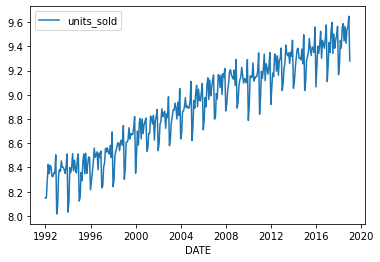

In [4]:
sns.lineplot(data=df)
plt.show()

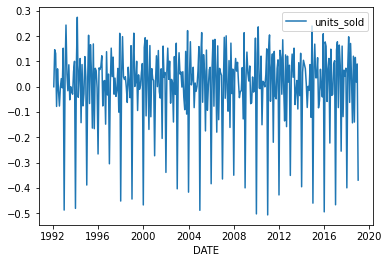

In [5]:
df_shift = df - df.shift()
df_shift.dropna(inplace=True)

sns.lineplot(data=df_shift)
plt.show()

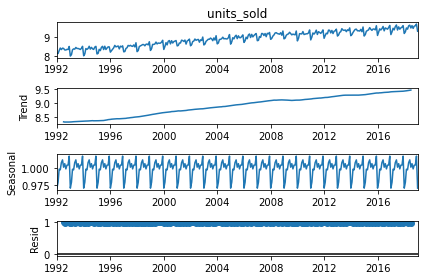

In [6]:
# Decompose transformed outcome into trend, seasonal, & residual components

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['units_sold'], model ='multiplicative')

result.plot()
plt.show()

In [7]:
# Use the auto-ARIMA function to determine how many seasonal and non-seasonal AR lags, differences, or MA components 
# are needed for the best fitting model on the transformed outcome. 
# This function uses stepwise variable selection procedures to find the best model.

from pmdarima import auto_arima

stepwise_fit = auto_arima(df['units_sold'], start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          #error_action ='ignore',
                          #suppress_warnings = True, 
                          stepwise = True) 

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-978.754, Time=0.83 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-980.093, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-979.256, Time=0.74 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-980.478, Time=0.64 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-806.538, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-979.404, Time=0.13 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.40 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=3.38 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-979.020, Time=0.91 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=5.20 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-981.813, Time=0.48 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=-1024.930, Time=2.39 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=4.40 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                             y   No. Observations:                  325
Model:             SARIMAX(0, 1, [1, 2], 12)   Log Likelihood                 516.465
Date:                       Wed, 09 Nov 2022   AIC                          -1024.930
Time:                               11:11:46   BIC                          -1009.945
Sample:                           01-01-1992   HQIC                         -1018.942
                                - 01-01-2019                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0455      0.001     47.722      0.000       0.044       0.047
ma.S.L12      -0.2334      0.065     -3.582      0.000      -0.361      -0.106
ma.S.L24      -0.5109      0.052     -9.732      0.000      -0.614      -0.408
sigma2         0.0021      0.000     12.732      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   4.32   Jarque-Bera (JB):                 5.75
Prob(Q):                              0.04   Prob(JB):                         0.06
Heteroskedasticity (H):               0.63   Skew:                            -0.32
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

What did the function find was the best fitting model? Explain what components it recommended.

- The function suggests an SARIMAX model
- The suggested (p,d,q) order is (0,0,0)
- And the seasonal order is (0,1,2,12)

## Section 2: Poisson Regression

In [23]:
df2 = pd.read_csv('ERdatOK.csv')

In [24]:
df2.head()

,Patients,Complication,Residency,Sex,RevPerHour,HoursService
0,1661,0,N,M,260.92,877.25
1,879,1,Y,M,206.42,705.25
2,1029,1,Y,F,287.76,1289
3,1486,1,Y,F,277.78,933.95
4,1780,1,N,M,236.32,1005.5


Answer the following:
- What is the outcome?
    - Count of treatment complications after emergency room care
- What are the predictors they want to understand the impact of?
    - The other variables are all predictors, i.e., Patients, Residency, Sex, RevPerHour, and HoursService
- What is the hypothesis?
    - H0: All the factors are not related to the outcome
    - H1: At least one factor is related to the outcome

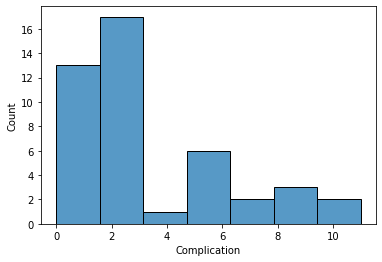

In [25]:
# Check whether the outcome is Poisson

sns.histplot(data=df2, x='Complication')

plt.show()

# Yes, this is a Poisson distribution.

In [26]:
# Look at the data to understand it and compute summary statistics. 
# When all values in a row of data are not clearly numeric, Python will make it an object. 
# To get summary measures on all the continuous variables, 
# you need to find problem values, fix them, and convert the column to numeric.

df2.info()

# HoursService should be numeric instead of an object.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Patients      44 non-null     int64  
 1   Complication  44 non-null     int64  
 2   Residency     44 non-null     object 
 3   Sex           44 non-null     object 
 4   RevPerHour    44 non-null     float64
 5   HoursService  44 non-null     object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.2+ KB


In [27]:
df2

# The HoursService value in rows 25 & 39 are problematic.

,Patients,Complication,Residency,Sex,RevPerHour,HoursService
0,1661,0,N,M,260.92,877.25
1,879,1,Y,M,206.42,705.25
2,1029,1,Y,F,287.76,1289
3,1486,1,Y,F,277.78,933.95
4,1780,1,N,M,236.32,1005.5
5,1863,1,Y,M,259.68,1168.25
6,2046,1,N,M,289.56,1029.75
7,2211,1,N,F,250.01,1548
8,2302,1,N,M,247.31,1486.25
9,2504,1,Y,F,218.70,1293.75


In [28]:
df2.loc[df2['HoursService']=='15.73.75', 'HoursService'] = '1573.75'
df2.loc[df2['HoursService']=='16.52.75', 'HoursService'] = '1652.75'

df2['HoursService'] = pd.to_numeric(df2['HoursService'])

# We have to change those values to correct format.

In [29]:
df2.describe()

,Patients,Complication,RevPerHour,HoursService
count,44.000000,44.000000,44.000000,44.000000
mean,2385.590909,3.340909,260.370227,1378.089773
std,627.289938,2.769797,32.433593,270.362404
min,879.000000,0.000000,206.420000,705.250000
25%,2035.750000,1.000000,237.062500,1240.437500
50%,2384.500000,2.000000,258.490000,1418.875000
75%,2813.000000,5.000000,282.330000,1558.000000
max,3763.000000,11.000000,334.940000,1867.250000


In [30]:
# Use .value_counts() to look at the frequencies of the two binary variables. 
# To use them in a model, they will also have to be converted to numeric values.

df2['Residency'].value_counts()

N    25
Y    19
Name: Residency, dtype: int64

In [31]:
df2['Sex'].value_counts()

M    32
F    12
Name: Sex, dtype: int64

In [32]:
df2['Residency'] = np.where(df2['Residency'] == 'Y', 1, 0)
df2['Sex'] = np.where(df2['Sex'] == 'M', 1, 0)

df2.head()

,Patients,Complication,Residency,Sex,RevPerHour,HoursService
0,1661,0,0,1,260.92,877.25
1,879,1,1,1,206.42,705.25
2,1029,1,1,0,287.76,1289.00
3,1486,1,1,0,277.78,933.95
4,1780,1,0,1,236.32,1005.50


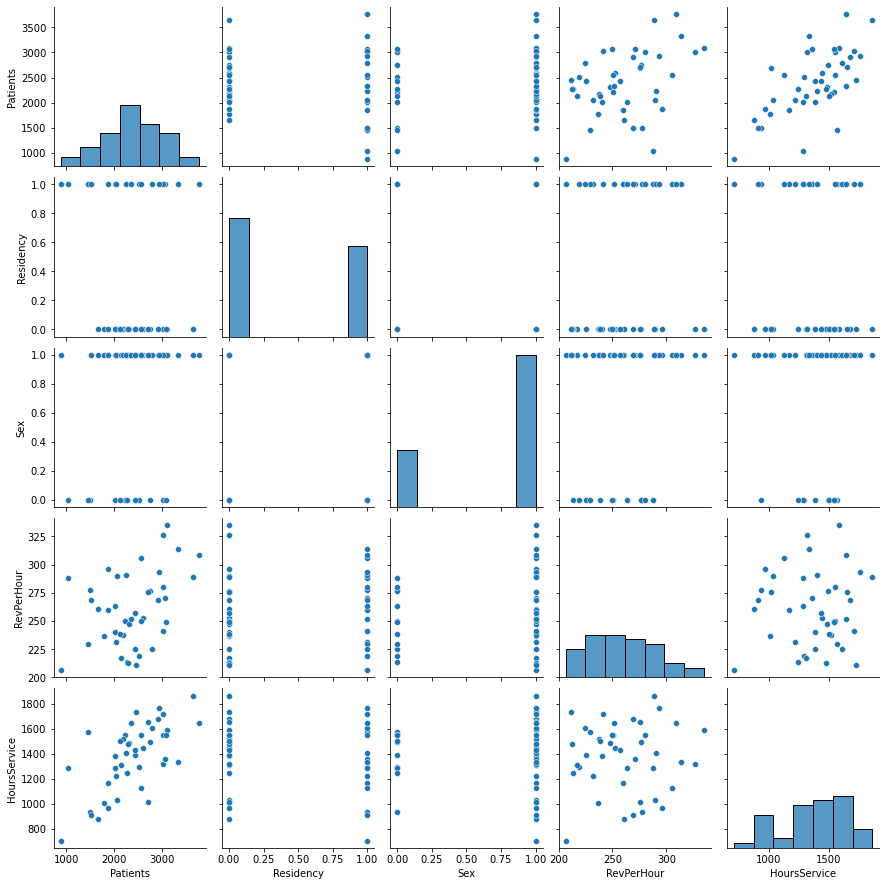

In [33]:
# Look at distributions of the other data values.

X = df2.drop(columns=['Complication'])

sns.pairplot(data=X)

plt.show()

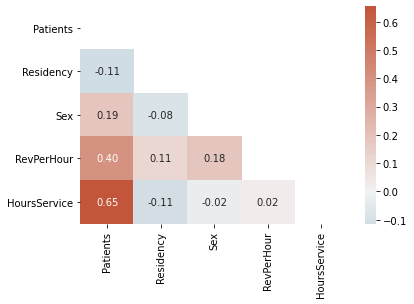

In [34]:
# To evaluate collinearity, check to see if any covariates are correlated.

corr = X.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt='.2f', center=0)

plt.show()

# Patients and HoursService, Patients and RevPerHour have stronger correlation.

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif

# The VIF of the three variables are very high, so we should consider dropping one of them.

,Variable,VIF
0,Patients,33.313316
1,Residency,1.850225
2,Sex,3.948318
3,RevPerHour,28.422757
4,HoursService,34.934508


In [36]:
# Fit a Poisson model and interpret the results.

import statsmodels.api as sm

X = X.drop(columns=['HoursService']) # Dropping HoursService which has the highest VIF
X = sm.add_constant(X)
y = df2['Complication']

model = sm.GLM(y, X,
               offset=np.log(X['Patients']),
               family=sm.families.Poisson())

result = model.fit()

print(result.summary())

# Only Patients shows significant relationship with the outcome. 
# There is positive corelation between number of patients and count of complications.

                 Generalized Linear Model Regression Results                  
Dep. Variable:           Complication   No. Observations:                   44
Model:                            GLM   Df Residuals:                       39
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -87.277
Date:                Wed, 09 Nov 2022   Deviance:                       51.774
Time:                        21:53:44   Pearson chi2:                     52.1
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2328
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.8804      0.660    -10.426      0.0

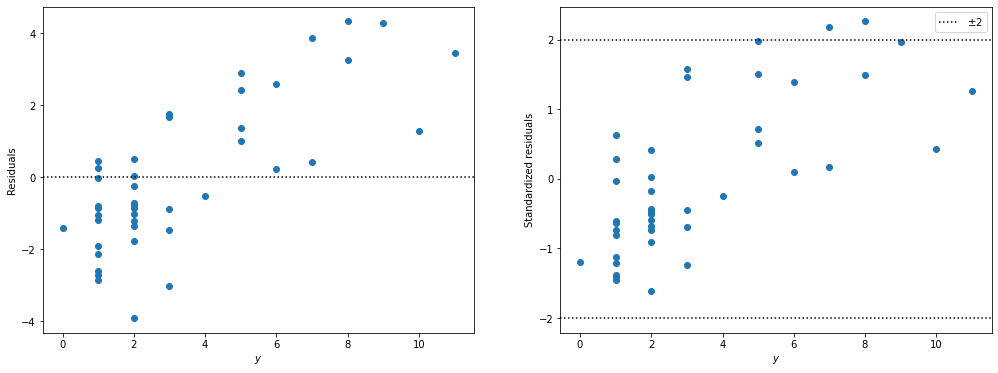

In [38]:
# Use plots to check the fit and for overdispersion. What do the plots tell you?

f, axes = plt.subplots(1, 2, figsize=(17, 6))

axes[0].plot(y, result.resid_response, 'o')
axes[0].axhline(y=0, linestyle=':', color='black')
axes[0].set_ylabel("Residuals")
axes[0].set_xlabel("$y$")

axes[1].plot(y, result.resid_pearson, 'o')
axes[1].axhline(y=-2, linestyle=':', color='black', label='$\pm 2$')
axes[1].axhline(y=+2, linestyle=':', color='black')
axes[1].set_ylabel("Standardized residuals")
axes[1].set_xlabel("$y$")

plt.legend()
plt.show()

# From the residual plot, we see that the variance increases with the fitted values. 
# However, most of the standardized residuals are within 2 standard deviations. There seems to be no overdispersion issue.